# Prediction of the movie revenue

### This dataset *movies_new.csv* can be downloaded from Google drive: https://drive.google.com/drive/folders/1MwFoUvUp2St0Sjq0I9dlNIl_BXkw3fZU

In [1]:
# import the library
%matplotlib inline

import ast
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

    
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold

from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score

# sklearn :: evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# apply style to all the charts
sns.set_style('whitegrid')

# convert scientific notation to decimals
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 24)

# Reading the Data

In [2]:
df = pd.read_csv('../data/movies_new.csv')
#df = pd.read_csv('data/movies.csv')
df['release_date'] = pd.to_datetime(df['release_date'])
print(df.dtypes)

id                                int64
title                            object
budget                            int64
revenue                         float64
production_countries             object
release_date             datetime64[ns]
popularity                      float64
vote_average                    float64
vote_count                      float64
genres                           object
production_companies             object
belongs_to_collection            object
cast                             object
keywords                         object
dtype: object


In [3]:
#Setting cast, production_companies, genres and keywords types to a list of dictionaries

df['genres'] = df['genres'].astype(str)
df['production_companies'] = df['production_companies'].astype(str)
df['cast'] = df['cast'].astype(str)
df['keywords'] = df['keywords'].astype(str)
df['production_countries'] = df['production_countries'].astype(str)
# df['belongs_to_collection'] = df['belongs_to_collection'].astype(str)

df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x))
df['production_companies'] = df['production_companies'].apply(lambda x: ast.literal_eval(x))
df['cast'] = df['cast'].apply(lambda x: ast.literal_eval(x))
df['keywords'] = df['keywords'].apply(lambda x: ast.literal_eval(x))
df['production_countries'] = df['production_countries'].apply(lambda x: ast.literal_eval(x))
# df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: ast.literal_eval(x))

Some adjustments

In [4]:
#Extra adjustments for the points discovered later during the process

#replace FRF budget by USD
df.loc[df['id'] == 10656, ['budget']] = 25974
print(df.loc[df['id'] == 10656, ['title']])

#wrong revenue
df.loc[df['id'] == 9838, ['revenue']] = 15057465
print(df.loc[df['id'] == 9838, ['title']])

       title
2134  Subway
                     title
1242  King Solomon's Mines


In [5]:
# Analize release date
# We see that there is a strong tendency of grouth movies produced every year
df['year'] = df['release_date'].dt.year
df['year_month'] = pd.to_datetime(df['release_date']).dt.to_period('M')

### Choosing time period

In [6]:
#Slicing our data 

df = df[(df['year']>=2000)]

print(df.shape)

(3112, 16)


In [7]:
df.head(5)

,id,title,budget,revenue,production_countries,release_date,popularity,vote_average,vote_count,genres,production_companies,belongs_to_collection,cast,keywords,year,year_month
3,121173,Voracious,11178,34659.000,"[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2012-09-05,0.079,8.000,1.000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'name': 'APT Entertainment', 'id': 8355}, {'...",0,"[{'cast_id': 16, 'character': 'Rene', 'credit_...","[{'id': 4694, 'name': 'staged death'}, {'id': ...",2012,2012-09
5,110428,Camille Claudel 1915,3512454,115860.000,"[{'iso_3166_1': 'FR', 'name': 'France'}]",2013-03-13,0.110,7.000,20.000,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Canal+', 'id': 5358}, {'name': 'Art...",0,"[{'cast_id': 3, 'character': 'Camille Claudel'...","[{'id': 254, 'name': 'france'}, {'id': 745, 'n...",2013,2013-03
6,110428,Camille Claudel 1915,3512454,115860.000,"[{'iso_3166_1': 'FR', 'name': 'France'}]",2013-03-13,0.110,7.000,20.000,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Canal+', 'id': 5358}, {'name': 'Art...",0,"[{'cast_id': 3, 'character': 'Camille Claudel'...","[{'id': 254, 'name': 'france'}, {'id': 745, 'n...",2013,2013-03
7,110428,Camille Claudel 1915,3512454,115860.000,"[{'iso_3166_1': 'FR', 'name': 'France'}]",2013-03-13,0.110,7.000,20.000,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Canal+', 'id': 5358}, {'name': 'Art...",0,"[{'cast_id': 3, 'character': 'Camille Claudel'...","[{'id': 254, 'name': 'france'}, {'id': 745, 'n...",2013,2013-03
8,110428,Camille Claudel 1915,3512454,115860.000,"[{'iso_3166_1': 'FR', 'name': 'France'}]",2013-03-13,0.110,7.000,20.000,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Canal+', 'id': 5358}, {'name': 'Art...",0,"[{'cast_id': 3, 'character': 'Camille Claudel'...","[{'id': 254, 'name': 'france'}, {'id': 745, 'n...",2013,2013-03


Kepping only movies which were produced in USA as the budget might be marked in US although in reality its not 

In [8]:
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value in item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]

#Extracting list of countries
l=[]
for i, item in enumerate(df['production_countries']):
    for cell in item:
        l.append(cell['name'])
p_name, p_count = np.unique(np.array(l), return_counts=True)

prod = zip(p_name, p_count) # list of Unique Values along with occurrence Count
prod = list(prod)
prod = sorted(prod, key = lambda x: x[1], reverse = True)
print('Number of production countries: ', len(prod))

df = df.iloc[index_extractor(df, 'production_countries', 'United States of America'),:]

print(df.shape)



Number of production countries:  68
(2522, 16)


# Choosing the columns

In [9]:

X = df[['title', 'budget', 'year', 'genres', 'production_companies', 'revenue',  'vote_count', 'vote_average',
        'belongs_to_collection', 'cast']]
# y = df['revenue']
# X = X.reset_index(drop=True)
# y = y.reset_index(drop=True)

# Feature engineering

### Budget

C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(array([  3.,   4.,  15.,  22.,  48., 127., 406., 965., 713., 219.]),
 array([ 8.85366543,  9.94386707, 11.0340687 , 12.12427034, 13.21447198,
        14.30467362, 15.39487526, 16.4850769 , 17.57527853, 18.66548017,
        19.75568181]),
 <a list of 10 Patch objects>)

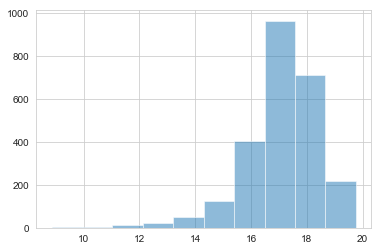

In [10]:
#plt.hist(X['budget'], alpha=0.5)
#print(X.groupby('budget')['id'].count())

X['budget'] = np.log(X['budget'])
plt.hist(X['budget'], alpha=0.5)

Removing outliers

In [11]:
# print(X['budget'].describe())

# mean_a = np.mean(X['budget'])
# std_a = np.std(X['budget'])

# X = X[(X['budget']>mean_a-3*std_a)&(X['budget']<mean_a+3*std_a)]

# print('After removing outliers:')
# print(X['budget'].describe())

# plt.figure()
# plt.hist(X['budget'])
# plt.show

### Revenue

(array([2.185e+03, 2.050e+02, 7.800e+01, 3.900e+01, 9.000e+00, 4.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([1.40400000e+03, 2.78797772e+08, 5.57594141e+08, 8.36390509e+08,
        1.11518688e+09, 1.39398325e+09, 1.67277961e+09, 1.95157598e+09,
        2.23037235e+09, 2.50916872e+09, 2.78796509e+09]),
 <a list of 10 Patch objects>)

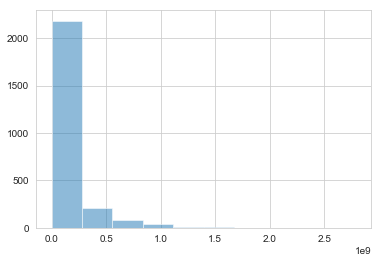

In [12]:
#plt.hist(X['revenue'])

#X['revenue'] = np.log(X['revenue'])
plt.hist(X['revenue'], alpha=0.5)

Removing outliers

In [13]:
# print(X['revenue'].describe())

# mean_a = np.mean(X['revenue'])
# std_a = np.std(X['revenue'])

# X = X[(X['revenue']>mean_a-3*std_a)&(X['revenue']<mean_a+3*std_a)]

# print('After removing outliers:')
# print(X['revenue'].describe())

# plt.figure()
# plt.hist(X['revenue'])
# plt.show

### Vote count

Removed from prediction as we wont be able to input this feature in our API

In [14]:
# plt.hist(X['vote_count'], bins=50)

### Vote average

Removed from prediction as we wont be able to input this feature in our API

In [15]:
# plt.hist(X['vote_average'], bins=50)

Removing outliers

In [16]:
# print(X['vote_average'].describe())

# mean_a = np.mean(X['vote_average'])
# std_a = np.std(X['vote_average'])

# X = X[(X['vote_average']>mean_a-3*std_a)&(X['vote_average']<mean_a+3*std_a)]

# print('After removing outliers:')
# print(X['vote_average'].describe())

# plt.figure()
# plt.hist(X['vote_average'])
# plt.show

### Popularity

Removed from prediction as this feature showed to be changing with the time. It depends on the current interest of public to the movie. I means that the most popular movies in this dataset are the ones that were released right before extracting the data 

In [17]:
# plt.hist(X['popularity'])

Removing outliers

In [18]:

# print(X['popularity'].describe())

# mean_a = np.mean(X['popularity'])
# std_a = np.std(X['popularity'])

# X = X[(X['popularity']>mean_a-3*std_a)&(X['popularity']<mean_a+3*std_a)]

# print('After removing outliers:')
# print(X['popularity'].describe())

# plt.figure()
# plt.hist(X['popularity'])
# plt.show

### Belongs_to_collection

In [19]:
coll = [0 if col == '0' else 1 for col in X['belongs_to_collection']]
X['collection'] = coll
# del X['belongs_to_collection']

C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Creating a new volumn: average of the of number of votes of all movies in each collection. And assigning this values to the movies which belongs to the collection. Here number of votes will be the measure of movie popularity (more votes - higher popularity). As we've learned that popularity feature doesn't reflect real picture as it is mesured in a timely manner (older movies are not popular as now people are not checking them out on IMDB)

In [20]:
X.reset_index(inplace=True, drop=True)
df['belongs_to_collection'] = df['belongs_to_collection'].astype(str)

index_extractor = lambda df, field, value: [idx for idx, item in enumerate(df[field]) if value == item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]

#Extracting list of collections
l=[]
index_0 = []
for i, item in enumerate(X['belongs_to_collection']):
    if item.strip() != '0':
        item = ast.literal_eval(item)
        l.append(item['name'])
    else:
        index_0.append(i)

d = {"id": 0, "name": 'No Name', "poster_path": None, "backdrop_path": None}
X['belongs_to_collection'] = [d if idx in index_0 else ast.literal_eval(item) for idx, item in enumerate(X['belongs_to_collection'])]

c_name, c_count = np.unique(np.array(l), return_counts=True)

# collection = zip(c_name, c_count) # list of collections with num of movies and average popularity
# collection = list(collection)
# collection = sorted(collection, key = lambda x: x[1], reverse = True)
# c_name=[]
# c_count=[]
# for i in range(len(collection)):
#     c_name.append(collection[i][0])
#     c_count.append(collection[i][1])

#Creating mean count_votes for each collection
index_extractor = lambda df, field, value: [idx for idx, item in enumerate(df['belongs_to_collection']) if type(item) != str if coll == item['name']]
list_pop_creator =  lambda df, idx: [df.loc[i,'vote_count'] if i in idx else 0 for i in df.index] # List of popularities for current actor

X['coll_vote'] = [0 for i in range(len(X.index))]

c_pop = []
for coll, count in zip(c_name, c_count):
    idx = index_extractor(X, 'belongs_to_collection', coll)
    list_pop = list_pop_creator(X, idx) 
    vote_count_ave = (np.sum(list_pop)/count) 
    X['coll_vote'] = [vote_count_ave if i in idx else item for i, item in enumerate(X['coll_vote'])]

    c_pop.append(vote_count_ave)
del X['belongs_to_collection']



C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

Exporting these features for external usage

In [21]:
df_collection = pd.DataFrame(data=[c_name, c_pop]).T
df_collection.columns=['name', 'vote_count']
df_collection = df_collection.sort_values(by='vote_count',ascending=False)
df_collection.reset_index(drop=True, inplace=True)
df_collection.to_csv('../data/collections.csv', index=False)
df_collection.head(10)

,name,vote_count
0,Avatar Collection,12114.000
1,Deadpool Collection,11444.000
2,The Dark Knight Collection,9681.000
3,Mad Max Collection,9629.000
4,The Avengers Collection,9454.000
5,Iron Man Collection,8290.333
6,The Lord of the Rings Collection,8253.000
7,Guardians of the Galaxy Collection,7436.000
8,Captain America Collection,6839.000
9,Man of Steel Collection,6825.500


### Genres

In [22]:
X.reset_index(inplace=True, drop=True)
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value == item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]

#Extracting list of genres
l=[]
for i, item in enumerate(X['genres']):
    for cell in item:
        l.append(cell['name'])
g_name, g_count = np.unique(np.array(l), return_counts=True)

# Create column for every genre and assigh 1 or 0
for genre in g_name:
    idx = index_extractor(X, 'genres', genre)
    c = list_creator(X, idx)
    genre_col = pd.Series(c)    
    X = X.assign(genre_col=genre_col.values)
    X.rename(columns={'genre_col':'{0}'.format(genre)}, inplace=True)

Creating new features: average vote number, average vote and ave revenue of the genres of each movie

In [23]:
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value == item['name']]
list_vote_count_creator =  lambda df, idx: [df.loc[i,'vote_count'] if i in idx else 0 for i in df.index] # List of popularities for current actor
list_vote_ave_creator =  lambda df, idx: [df.loc[i,'vote_average'] if i in idx else 0 for i in df.index] # List of popularities for current actor
list_rev_creator =  lambda df, idx: [df.loc[i,'revenue'] if i in idx else 0 for i in df.index] # List of popularities for current actor

X['g_vote_count'] = [0 for i in range(len(X.index))]
X['g_vote_ave'] = [0 for i in range(len(X.index))]
X['g_rev_ave'] = [0 for i in range(len(X.index))]

g_pop = []
g_vote = []
g_rev = []
for genre, count in zip(g_name, g_count):
    idx = index_extractor(X, 'genres', genre)
    
    list_vote_count = list_vote_count_creator(X, idx) 
    list_vote_ave = list_vote_ave_creator(X, idx) 
    list_rev_ave = list_rev_creator(X, idx) 
    
    vote_count_ave = (np.sum(list_vote_count)/count)
    vote_ave = (np.sum(list_vote_ave)/count)
    rev_ave = (np.sum(list_rev_ave)/count)
    
    g_pop.append(vote_count_ave)
    g_vote.append(vote_ave)
    g_rev.append(rev_ave)

    X['g_vote_count'] = [item + vote_count_ave if i in idx else item for i, item in enumerate(X['g_vote_count'])]
    X['g_vote_ave'] = [item + vote_ave if i in idx else item for i, item in enumerate(X['g_vote_ave'])]
    X['g_rev_ave'] = [item + rev_ave if i in idx else item for i, item in enumerate(X['g_rev_ave'])]

genres = zip(g_name, g_pop, g_vote, g_rev) # to export to API


X.head()

,title,budget,year,genres,production_companies,revenue,vote_count,vote_average,cast,collection,coll_vote,Action,...,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,g_vote_count,g_vote_ave,g_rev_ave
0,Cruel World,14.509,2005,"[{'id': 53, 'name': 'Thriller'}, {'id': 27, 'n...","[{'name': 'Primetime Pictures', 'id': 36417}, ...",16344.000,6.000,4.800,"[{'cast_id': 1, 'character': 'Philip Markham',...",0,0.000,0,...,0,1,0,0,0,0,1,0,0,2681.822,17.644,300663711.615
1,Behind the Burly Q,12.429,2010,"[{'id': 99, 'name': 'Documentary'}]","[{'name': 'Mistress Inc.', 'id': 38568}]",23859.000,3.000,5.500,"[{'cast_id': 2, 'character': '. Himself (arc...",0,0.000,0,...,0,0,0,0,0,0,0,0,0,152.667,6.700,27019585.481
2,The Internship,17.876,2013,"[{'id': 35, 'name': 'Comedy'}]",[{'name': 'Twentieth Century Fox Film Corporat...,44000000.000,1691.000,6.100,"[{'cast_id': 7, 'character': 'Nick Campbell', ...",0,0.000,0,...,0,0,0,0,0,0,0,0,0,840.731,5.987,120680934.450
3,Resident Evil: Afterlife,17.910,2010,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'name': 'Impact Pictures', 'id': 248}, {'nam...",300228084.000,1382.000,5.800,"[{'cast_id': 11, 'character': 'Alice', 'credit...",1,1538.800,1,...,0,1,0,0,0,1,0,0,0,6825.502,23.897,831969592.454
4,Eye of the Dolphin,14.732,2007,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Gold/Miller Productions', 'id': 160...",71904.000,7.000,7.100,"[{'cast_id': 1, 'character': 'Alyssa', 'credit...",1,7.000,0,...,0,0,0,0,0,0,0,0,0,857.845,6.437,81186168.358


In [24]:
#Reassigning average instead of sum
for i in X.index:
    count = len(X.loc[i, 'genres'])
    X.loc[i,'g_vote_count'] = X.loc[i,'g_vote_count']/count
    X.loc[i,'g_vote_ave'] = X.loc[i,'g_vote_ave']/count
    X.loc[i,'g_rev_ave'] = X.loc[i,'g_rev_ave']/count
del X['genres']

In [25]:
X.head()

,title,budget,year,production_companies,revenue,vote_count,vote_average,cast,collection,coll_vote,Action,Adventure,...,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,g_vote_count,g_vote_ave,g_rev_ave
0,Cruel World,14.509,2005,"[{'name': 'Primetime Pictures', 'id': 36417}, ...",16344.000,6.000,4.800,"[{'cast_id': 1, 'character': 'Philip Markham',...",0,0.000,0,0,...,0,1,0,0,0,0,1,0,0,893.941,5.881,100221237.205
1,Behind the Burly Q,12.429,2010,"[{'name': 'Mistress Inc.', 'id': 38568}]",23859.000,3.000,5.500,"[{'cast_id': 2, 'character': '. Himself (arc...",0,0.000,0,0,...,0,0,0,0,0,0,0,0,0,152.667,6.700,27019585.481
2,The Internship,17.876,2013,[{'name': 'Twentieth Century Fox Film Corporat...,44000000.000,1691.000,6.100,"[{'cast_id': 7, 'character': 'Nick Campbell', ...",0,0.000,0,0,...,0,0,0,0,0,0,0,0,0,840.731,5.987,120680934.450
3,Resident Evil: Afterlife,17.910,2010,"[{'name': 'Impact Pictures', 'id': 248}, {'nam...",300228084.000,1382.000,5.800,"[{'cast_id': 11, 'character': 'Alice', 'credit...",1,1538.800,1,1,...,0,1,0,0,0,1,0,0,0,1706.376,5.974,207992398.114
4,Eye of the Dolphin,14.732,2007,"[{'name': 'Gold/Miller Productions', 'id': 160...",71904.000,7.000,7.100,"[{'cast_id': 1, 'character': 'Alyssa', 'credit...",1,7.000,0,0,...,0,0,0,0,0,0,0,0,0,857.845,6.437,81186168.358


Exporting these features for external usage

In [26]:
df_genre = pd.DataFrame(data=[g_name, g_pop, g_vote, g_rev]).T
df_genre.columns=['name', 'vote_count', 'vote_average', 'revenue']
df_genre = df_genre.sort_values(by='revenue',ascending=False)
df_genre.reset_index(drop=True, inplace=True)
df_genre.to_csv('../data/genres.csv', index=False)
df_genre.head(10)

,name,vote_count,vote_average,revenue
0,Fantasy,2104.459,6.142,316451295.136
1,Animation,1604.797,6.335,315781713.320
2,Adventure,2160.489,6.185,312223459.404
3,Family,1404.137,6.130,272788195.513
4,Science Fiction,2155.693,6.050,235168729.217
5,Action,1779.659,6.068,214781787.533
6,Comedy,840.731,5.987,120680934.450
7,War,1092.549,6.537,119781985.789
8,Thriller,1111.430,6.062,110187160.866
9,History,877.689,6.647,100342206.757


In [27]:
X.head()

,title,budget,year,production_companies,revenue,vote_count,vote_average,cast,collection,coll_vote,Action,Adventure,...,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,g_vote_count,g_vote_ave,g_rev_ave
0,Cruel World,14.509,2005,"[{'name': 'Primetime Pictures', 'id': 36417}, ...",16344.000,6.000,4.800,"[{'cast_id': 1, 'character': 'Philip Markham',...",0,0.000,0,0,...,0,1,0,0,0,0,1,0,0,893.941,5.881,100221237.205
1,Behind the Burly Q,12.429,2010,"[{'name': 'Mistress Inc.', 'id': 38568}]",23859.000,3.000,5.500,"[{'cast_id': 2, 'character': '. Himself (arc...",0,0.000,0,0,...,0,0,0,0,0,0,0,0,0,152.667,6.700,27019585.481
2,The Internship,17.876,2013,[{'name': 'Twentieth Century Fox Film Corporat...,44000000.000,1691.000,6.100,"[{'cast_id': 7, 'character': 'Nick Campbell', ...",0,0.000,0,0,...,0,0,0,0,0,0,0,0,0,840.731,5.987,120680934.450
3,Resident Evil: Afterlife,17.910,2010,"[{'name': 'Impact Pictures', 'id': 248}, {'nam...",300228084.000,1382.000,5.800,"[{'cast_id': 11, 'character': 'Alice', 'credit...",1,1538.800,1,1,...,0,1,0,0,0,1,0,0,0,1706.376,5.974,207992398.114
4,Eye of the Dolphin,14.732,2007,"[{'name': 'Gold/Miller Productions', 'id': 160...",71904.000,7.000,7.100,"[{'cast_id': 1, 'character': 'Alyssa', 'credit...",1,7.000,0,0,...,0,0,0,0,0,0,0,0,0,857.845,6.437,81186168.358


### Production Companies

In [28]:
X.reset_index(inplace=True, drop=True)
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value == item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]

#Extracting list of production_companies
l=[]
for i, item in enumerate(X['production_companies']):
    for cell in item:
        l.append(cell['name'])
p_name, p_count = np.unique(np.array(l), return_counts=True)

prod = zip(p_name, p_count) # list of Unique Values along with occurrence Count
prod = list(prod)
prod = sorted(prod, key = lambda x: x[1], reverse = True)
print('Number of production companies: ', len(prod))
    
#100 companies which produced the hihest number of movies
p_name = []
p_count = []
for i in range(100):
    p_name.append(prod[i][0])
    p_count.append(prod[i][1])


Number of production companies:  2948


In [29]:
# s = '"", '
# for i in sorted(p_name):
#     s = s + '"' + i + '", '
# print(s)

In [30]:
len(p_name)

100

In [31]:
# Create column for every production companie and assigh 1 or 0
for p_n in p_name:
    idx = index_extractor(X, 'production_companies', p_n)
    c = list_creator(X, idx)
    prod_col = pd.Series(c)    
    X = X.assign(prod_col=prod_col.values)
    X.rename(columns={'prod_col':'{0}'.format(p_n)}, inplace=True)


Create new features

In [32]:
# Reassign to p_name all of the companies
p_name = []
p_count = []
for i in range(len(prod)):
    p_name.append(prod[i][0])
    p_count.append(prod[i][1])

In [33]:
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value == item['name']]
list_vote_count_creator =  lambda df, idx: [df.loc[i,'vote_count'] if i in idx else 0 for i in df.index] # List of popularities for current actor
list_vote_ave_creator =  lambda df, idx: [df.loc[i,'vote_average'] if i in idx else 0 for i in df.index] # List of popularities for current actor
list_rev_creator =  lambda df, idx: [df.loc[i,'revenue'] if i in idx else 0 for i in df.index] # List of popularities for current actor

X['p_vote_count'] = [0 for i in range(len(X.index))]
X['p_vote_ave'] = [0 for i in range(len(X.index))]
X['p_rev_ave'] = [0 for i in range(len(X.index))]

p_pop = []
p_vote = []
p_rev = []
for prod, count in zip(p_name, p_count):
    idx = index_extractor(X, 'production_companies', prod)
    
    list_vote_count = list_vote_count_creator(X, idx) 
    list_vote_ave = list_vote_ave_creator(X, idx) 
    list_rev_ave = list_rev_creator(X, idx) 
    
    vote_count_ave = (np.sum(list_vote_count)/count)
    vote_ave = (np.sum(list_vote_ave)/count)
    rev_ave = (np.sum(list_rev_ave)/count)
    
    p_pop.append(vote_count_ave)
    p_vote.append(vote_ave)
    p_rev.append(rev_ave)

    X['p_vote_count'] = [item + vote_count_ave if i in idx else item for i, item in enumerate(X['p_vote_count'])]
    X['p_vote_ave'] = [item + vote_ave if i in idx else item for i, item in enumerate(X['p_vote_ave'])]
    X['p_rev_ave'] = [item + rev_ave if i in idx else item for i, item in enumerate(X['p_rev_ave'])]


In [34]:
#Reassigning average instead of sum
for i in X.index:
    count = len(X.loc[i, 'production_companies'])
    X.loc[i,'p_vote_count'] = X.loc[i,'p_vote_count']/count
    X.loc[i,'p_vote_ave'] = X.loc[i,'p_vote_ave']/count
    X.loc[i,'p_rev_ave'] = X.loc[i,'p_rev_ave']/count
del X['production_companies']

Exporting these features for external usage

In [35]:
df_prod = pd.DataFrame(data=[p_name, p_pop, p_vote, p_rev]).T
df_prod.columns=['name', 'vote_count', 'vote_average', 'revenue']
df_prod = df_prod.sort_values(by='revenue',ascending=False)
df_prod.reset_index(drop=True, inplace=True)
df_prod.to_csv('../data/prod_companies.csv', index=False)
df_prod.head(10)

,name,vote_count,vote_average,revenue
0,Truenorth Productions,7993.000,7.500,2068223624.000
1,"Colorado Office of Film, Television & Media",4253.000,7.300,1506249360.000
2,Abu Dhabi Film Commission,4253.000,7.300,1506249360.000
3,Lightstorm Entertainment,6246.000,6.550,1408983922.500
4,Deluxe Digital Studios,7462.000,7.100,1153304495.000
5,Vita-Ray Dutch Productions (III),7462.000,7.100,1153304495.000
6,Ian Bryce Productions,3136.000,5.800,1091405097.000
7,Black Hangar Studios,5111.000,7.400,1056057273.000
8,Second Mate Productions,5003.500,6.950,1013329906.000
9,3Foot7,4884.000,7.100,956019788.000


### Cast

In [36]:
X.reset_index(inplace=True, drop=True)
#Extracting list of actors
l=[]
for i, item in enumerate(X['cast']):
    for cell in item:
        l.append(cell['name'])
a_name, a_count = np.unique(np.array(l), return_counts=True)
idx=[]
for i, item  in enumerate(a_name):
    if (item == 'Kar') | (item == 'George') | (a_name[i] == 'Mario') | (a_name[i] == 'Jack') | (a_name[i] == 'Charle') | (a_name[i] == 'Charlie') | (a_name[i] == 'Mars') | (a_name[i] == 'Terry') | (a_name[i] == 'King') | (a_name[i] == 'Sim') | (a_name[i] == 'Elli') | (a_name[i] == 'Carlos') | (a_name[i] == 'Sandra') | (a_name[i] == 'Justin') | (a_name[i] == 'Shane') | (a_name[i] == 'Angela') | (a_name[i] == 'Eve') | (a_name[i] == 'Foster') | (a_name[i] == 'Take') | (a_name[i] == 'Andrea') | (a_name[i] == 'Ade') | (a_name[i] == 'Tiffany') | (a_name[i] == 'Zoë'):
        idx.append(i)
    
a_name = np.delete(a_name, idx)
a_count = np.delete(a_count, idx)

act = zip(a_name, a_count) # list of Unique Values along with occurrence Count
act = list(act)
act = sorted(act, key = lambda x: x[1], reverse = True)
print('Number of actors: ', len(act))

#actors which produced the hihest number of movies
a_name = []
a_count = []

for i in range(len(act)):
    if act[i][1] > 20:
        a_name.append(act[i][0])
        a_count.append(act[i][1])

        
print(len(a_name), len(a_count))

Number of actors:  36856
122 122


In [37]:
s = '"", '
for i in sorted(a_name):
    s = s + '"' + i + '", '
print(s)

"", "Aaron Eckhart", "Adam Sandler", "Alan Tudyk", "Alec Baldwin", "Amy Adams", "Angelina Jolie", "Anna Faris", "Anne Hathaway", "Anthony Mackie", "Ben Affleck", "Ben Kingsley", "Ben Stiller", "Bill Hader", "Bill Murray", "Bill Nighy", "Brad Pitt", "Bradley Cooper", "Brendan Gleeson", "Brian Cox", "Bruce McGill", "Bruce Willis", "Cameron Diaz", "Cate Blanchett", "Channing Tatum", "Charlize Theron", "Chris Cooper", "Chris Evans", "Christian Bale", "Ciarán Hinds", "Colin Farrell", "David Koechner", "Dennis Quaid", "Drew Barrymore", "Dwayne Johnson", "Ed Harris", "Elizabeth Banks", "Ewan McGregor", "Fred Tatasciore", "George Clooney", "Gerard Butler", "Hugh Jackman", "Idris Elba", "J.K. Simmons", "Jack Black", "James Franco", "James Marsden", "Jamie Foxx", "Jason Bateman", "Jason Statham", "Jennifer Aniston", "Jeremy Renner", "Joe Chrest", "John C. Reilly", "John Goodman", "John Leguizamo", "Johnny Depp", "Jonah Hill", "Joseph Gordon-Levitt", "Josh Brolin", "Jude Law", "Judy Greer", "Juli

In [38]:
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value == item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]
# Create column for every actor and assigh 1 or 0
for actor in a_name:
    idx = index_extractor(X, 'cast', actor)
    c = list_creator(X, idx)
    prod_col = pd.Series(c)    
    X = X.assign(prod_col=prod_col.values)
    X.rename(columns={'prod_col':'{0}'.format(actor)}, inplace=True)


Create numeric features

In [39]:
# Reassign to a_name all of the actors
a_name = []
a_count = []

for i in range(len(act)):
    a_name.append(act[i][0])
    a_count.append(act[i][1])

In [40]:
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value == item['name']]
list_vote_count_creator =  lambda df, idx: [df.loc[i,'vote_count'] if i in idx else 0 for i in df.index] # List of popularities for current actor
list_vote_ave_creator =  lambda df, idx: [df.loc[i,'vote_average'] if i in idx else 0 for i in df.index] # List of popularities for current actor
list_rev_creator =  lambda df, idx: [df.loc[i,'revenue'] if i in idx else 0 for i in df.index] # List of popularities for current actor

X['a_vote_count'] = [0 for i in range(len(X.index))]
X['a_vote_ave'] = [0 for i in range(len(X.index))]
X['a_rev_ave'] = [0 for i in range(len(X.index))]

a_pop = []
a_vote = []
a_rev = []
for actor, count in zip(a_name, a_count):
    idx = index_extractor(X, 'cast', actor)
    
    list_vote_count = list_vote_count_creator(X, idx) 
    list_vote_ave = list_vote_ave_creator(X, idx) 
    list_rev_ave = list_rev_creator(X, idx) 
    
    vote_count_ave = (np.sum(list_vote_count)/count)
    vote_ave = (np.sum(list_vote_ave)/count)
    rev_ave = (np.sum(list_rev_ave)/count)
    
    a_pop.append(vote_count_ave)
    a_vote.append(vote_ave)
    a_rev.append(rev_ave)

    X['a_vote_count'] = [item + vote_count_ave if i in idx else item for i, item in enumerate(X['a_vote_count'])]
    X['a_vote_ave'] = [item + vote_ave if i in idx else item for i, item in enumerate(X['a_vote_ave'])]
    X['a_rev_ave'] = [item + rev_ave if i in idx else item for i, item in enumerate(X['a_rev_ave'])]


In [41]:
X.head()

,title,budget,year,revenue,vote_count,vote_average,cast,collection,coll_vote,Action,Adventure,Animation,...,Peter Sarsgaard,Ralph Fiennes,Ron Perlman,Sigourney Weaver,Susan Sarandon,Toby Jones,Tom Wilkinson,Vin Diesel,Zoe Saldana,a_vote_count,a_vote_ave,a_rev_ave
0,Cruel World,14.509,2005,16344.000,6.000,4.800,"[{'cast_id': 1, 'character': 'Philip Markham',...",0,0.000,0,0,0,...,0,0,0,0,0,0,0,0,0,2885.817,42.245,369186513.567
1,Behind the Burly Q,12.429,2010,23859.000,3.000,5.500,"[{'cast_id': 2, 'character': '. Himself (arc...",0,0.000,0,0,0,...,0,0,0,0,0,0,0,0,0,1102.571,33.814,126078973.857
2,The Internship,17.876,2013,44000000.000,1691.000,6.100,"[{'cast_id': 7, 'character': 'Nick Campbell', ...",0,0.000,0,0,0,...,0,0,0,0,0,0,0,0,0,195853.128,718.713,9075640833.202
3,Resident Evil: Afterlife,17.910,2010,300228084.000,1382.000,5.800,"[{'cast_id': 11, 'character': 'Alice', 'credit...",1,1538.800,1,1,0,...,0,0,0,0,0,0,0,0,0,18143.742,88.820,3078298399.528
4,Eye of the Dolphin,14.732,2007,71904.000,7.000,7.100,"[{'cast_id': 1, 'character': 'Alyssa', 'credit...",1,7.000,0,0,0,...,0,0,0,0,0,0,0,0,0,9110.383,112.585,949382564.133


In [42]:
#Reassigning average instead of sum
for i in X.index:
    count = len(X.loc[i, 'cast'])
    if i == 1:
        print(count)
    X.loc[i,'a_vote_count'] = X.loc[i,'a_vote_count']/count
    X.loc[i,'a_vote_ave'] = X.loc[i,'a_vote_ave']/count
    X.loc[i,'a_rev_ave'] = X.loc[i,'a_rev_ave']/count

del X['cast']

6


In [43]:
X.head()

,title,budget,year,revenue,vote_count,vote_average,collection,coll_vote,Action,Adventure,Animation,Comedy,...,Peter Sarsgaard,Ralph Fiennes,Ron Perlman,Sigourney Weaver,Susan Sarandon,Toby Jones,Tom Wilkinson,Vin Diesel,Zoe Saldana,a_vote_count,a_vote_ave,a_rev_ave
0,Cruel World,14.509,2005,16344.000,6.000,4.800,0,0.000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,360.727,5.281,46148314.196
1,Behind the Burly Q,12.429,2010,23859.000,3.000,5.500,0,0.000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,183.762,5.636,21013162.310
2,The Internship,17.876,2013,44000000.000,1691.000,6.100,0,0.000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1673.958,6.143,77569579.771
3,Resident Evil: Afterlife,17.910,2010,300228084.000,1382.000,5.800,1,1538.800,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1209.583,5.921,205219893.302
4,Eye of the Dolphin,14.732,2007,71904.000,7.000,7.100,1,7.000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,569.399,7.037,59336410.258


Exporting

In [44]:
df_act = pd.DataFrame(data=[a_name, a_pop, a_vote, a_rev]).T
df_act.columns=['name', 'vote_count', 'vote_average', 'revenue']
df_act = df_act.sort_values(by='revenue',ascending=False)
df_act.reset_index(drop=True, inplace=True)
df_act.to_csv('../data/actors.csv', index=False)
df_act.head(10)

,name,vote_count,vote_average,revenue
0,Frankie Torres,12114.000,7.200,2787965087.000
1,Sara Wilson,12114.000,7.200,2787965087.000
2,Michael Blain-Rozgay,12114.000,7.200,2787965087.000
3,Chris Mala,12114.000,7.200,2787965087.000
4,Kai Pantano,12114.000,7.200,2787965087.000
5,Melvin Leno Clark III,12114.000,7.200,2787965087.000
6,James Patrick Pitt,12114.000,7.200,2787965087.000
7,Gerry Blair,12114.000,7.200,2787965087.000
8,Lisa Roumain,12114.000,7.200,2787965087.000
9,Kyla Warren,12114.000,7.200,2787965087.000


In [45]:
X.head(5)

,title,budget,year,revenue,vote_count,vote_average,collection,coll_vote,Action,Adventure,Animation,Comedy,...,Peter Sarsgaard,Ralph Fiennes,Ron Perlman,Sigourney Weaver,Susan Sarandon,Toby Jones,Tom Wilkinson,Vin Diesel,Zoe Saldana,a_vote_count,a_vote_ave,a_rev_ave
0,Cruel World,14.509,2005,16344.000,6.000,4.800,0,0.000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,360.727,5.281,46148314.196
1,Behind the Burly Q,12.429,2010,23859.000,3.000,5.500,0,0.000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,183.762,5.636,21013162.310
2,The Internship,17.876,2013,44000000.000,1691.000,6.100,0,0.000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1673.958,6.143,77569579.771
3,Resident Evil: Afterlife,17.910,2010,300228084.000,1382.000,5.800,1,1538.800,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1209.583,5.921,205219893.302
4,Eye of the Dolphin,14.732,2007,71904.000,7.000,7.100,1,7.000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,569.399,7.037,59336410.258


# Saving to the file

In [46]:
X.head(5)
X.to_csv('../data/for_api.csv', index=False)

# Prediction

In [47]:
del X['title']
del X['vote_count']
del X['vote_average']

y = X['revenue']
del X['revenue']


#X = pd.DataFrame(normalize(X, axis=0))
# for col in X.columns:
#     X[col] = StandardScaler().fit_transform(X[col].values.reshape(-1, 1))

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
X.head(5)

,budget,year,collection,coll_vote,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,Peter Sarsgaard,Ralph Fiennes,Ron Perlman,Sigourney Weaver,Susan Sarandon,Toby Jones,Tom Wilkinson,Vin Diesel,Zoe Saldana,a_vote_count,a_vote_ave,a_rev_ave
0,14.509,2005,0,0.000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,360.727,5.281,46148314.196
1,12.429,2010,0,0.000,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,183.762,5.636,21013162.310
2,17.876,2013,0,0.000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1673.958,6.143,77569579.771
3,17.910,2010,1,1538.800,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1209.583,5.921,205219893.302
4,14.732,2007,1,7.000,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,569.399,7.037,59336410.258


In [48]:
list_columns=[]
for i in X.columns:
    list_columns.append(i)
print(len(list_columns))

254


In [49]:
scores = cross_val_score(RandomForestRegressor(500), X, y, cv=10)
print('cross_val_score', np.mean(scores))

cross_val_score 0.7743119606346742


### Grid Search

In [50]:
# from sklearn.model_selection import GridSearchCV
# # Create the parameter grid based on the results of random search 
# param_grid = {
# #    'bootstrap': [True],
# #    'max_depth': [80, 90, 100, 110],
# #    'max_features': [2, 3],
# #    'min_samples_leaf': [3, 4, 5],
# #    'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 500, 1000]
# }
# # Create a based model
# rf = RandomForestRegressor()
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# grid_search.fit(X, y)
# print(grid_search.best_params_)
# print(grid_search.best_score_)
# print(grid_search.best_estimator_)

MODEL RandomForestRegressor


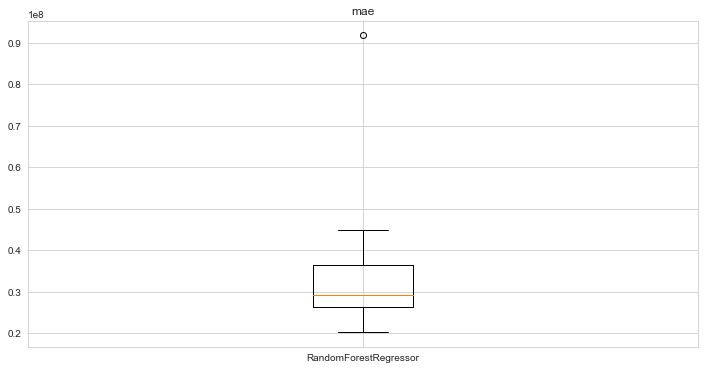

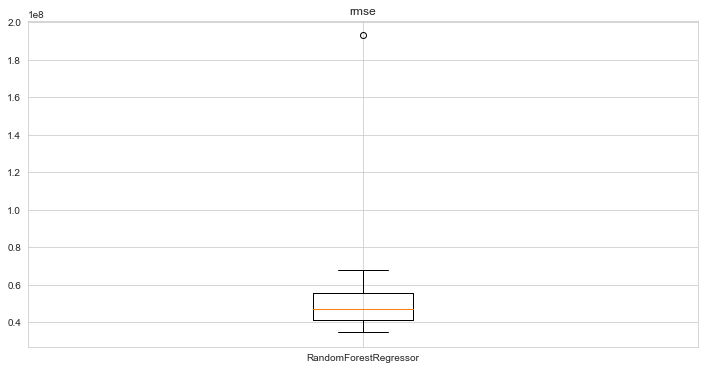

In [51]:
models = [ ('RandomForestRegressor', RandomForestRegressor(n_estimators=300, n_jobs=-1)),
           # ('Ridge Regressor', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=None, solver='auto', tol=0.001))
]
#('GradientBoosting', GradientBoostingRegressor()),
#('LinearRegression', LinearRegression()),
#('LassoRegressor', Lasso(alpha=0.1)),
#('RandomForestRegressor10', RandomForestRegressor(n_estimators=10)),
#('DecisionTreeRegressor', DecisionTreeRegressor())
#('KNeighborsRegressor', KNeighborsRegressor(5))

#('SVMRegressor', SVR()), - Slow - check the optimal C (find the function)
#('GaussianRegressor',GaussianProcessRegressor()),
#('SGDRegressor', SGDRegressor(), - bad results, check the parameters

k = 10
results = {}
for m in models:
    print('MODEL', m[0])
    results[m[0]] = {'mae':[], 'rmse':[]}
    kf = KFold(n_splits=k)
    for train_index, test_index in kf.split(X):
        X_train_k, X_test_k = X.values[train_index], X.values[test_index]
        y_train_k, y_test_k = y.values[train_index], y.values[test_index]
        model = m[1]
        model.fit(X_train_k, y_train_k.ravel())
        y_pred = model.predict(X_test_k)
        mae = mean_absolute_error(y_test_k, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_k, y_pred))
        results[m[0]]['mae'].append(mae)
        results[m[0]]['rmse'].append(rmse)
        
for metric in ['mae', 'rmse']:
    values = []
    labels = []
    for model, result_values in results.items():
        for m, v in result_values.items():
            if m == metric:
                labels.append(model)
                values.append(v)
    plt.figure(figsize=(12,6))
    plt.title(metric)
    plt.boxplot(values)
    plt.xticks(range(1, len(labels)+1), labels, rotation='horizontal')
    plt.show()

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print('X_train: ', X_train.shape, 'y_train:', y_train.shape, '\nX_test: ', X_test.shape, 'y_test: ', y_test.shape)
#print(X_train.head(5))
#model = LinearRegression()
model = RandomForestRegressor(500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

X_train:  (1689, 254) y_train: (1689,) 
X_test:  (833, 254) y_test:  (833,)


MAE 31558313.39002881


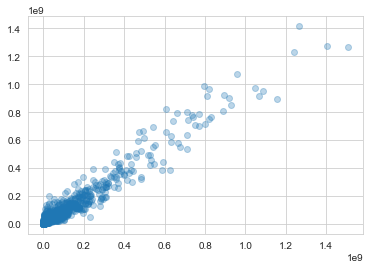

In [53]:
# Evaluate the model using the Mean Absolute Error
from sklearn.metrics import mean_absolute_error
print('MAE', mean_absolute_error(y_test, y_pred))

# plot the results
plt.scatter(y_test, y_pred, alpha=0.3)
plt.show()

### Feature Importances

In [54]:
print(model)
fi = []
for i, col in enumerate(X_test.columns):
    fi.append([col, model.feature_importances_[i]])
features = pd.DataFrame(fi).sort_values(1, ascending=False)
print(type(features))
print(features)
useless = list(features.loc[features[1] < 0.0003, 0])
print(useless)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
<class 'pandas.core.frame.DataFrame'>
                                          0     1
253                               a_rev_ave 0.893
128                               p_rev_ave 0.023
3                                 coll_vote 0.012
0                                    budget 0.011
251                            a_vote_count 0.009
23                             g_vote_count 0.006
252                              a_vote_ave 0.004
126                            p_vote_count 0.004
1                                      year 0.003
24                               g_vote_ave 0.003
127                      

### Error Analysis

In [55]:
df_new = pd.DataFrame(X_test).copy()
print(df_new.count())
print(len(y_pred))
df_new['revenue'] = y_test
df_new['prediction'] = y_pred
df_new['abs_error'] = abs(df_new['revenue']-df_new['prediction'])
df_new.sort_values(by='abs_error', ascending=False).round()
print(df_new.head())

budget                  833
year                    833
collection              833
coll_vote               833
Action                  833
Adventure               833
Animation               833
Comedy                  833
Crime                   833
Documentary             833
Drama                   833
Family                  833
Fantasy                 833
Foreign                 833
History                 833
Horror                  833
Music                   833
Mystery                 833
Romance                 833
Science Fiction         833
Thriller                833
War                     833
Western                 833
g_vote_count            833
g_vote_ave              833
g_rev_ave               833
Warner Bros.            833
Universal Pictures      833
Paramount Pictures      833
Columbia Pictures       833
                       ... 
Rosario Dawson          833
Ryan Reynolds           833
Sam Rockwell            833
Terrence Howard         833
Tom Hanks           

In [56]:
df_error = df_new[df_new['abs_error']>1]
#df_error.groupby()
df_error.corr()['abs_error'].dropna().sort_values()

Drama                       -0.135
Crime                       -0.098
Thriller                    -0.068
Horror                      -0.067
Millennium Films            -0.066
War                         -0.062
g_vote_ave                  -0.059
Bruce Willis                -0.056
Joe Chrest                  -0.054
Mystery                     -0.054
Happy Madison Productions   -0.053
Lions Gate Films            -0.053
Justin Long                 -0.052
BBC Films                   -0.051
Endgame Entertainment       -0.050
Adam Sandler                -0.049
Sigourney Weaver            -0.047
Drew Barrymore              -0.047
Ciarán Hinds                -0.044
Keith David                 -0.044
Rosario Dawson              -0.043
Nu Image Films              -0.043
Michael Shannon             -0.042
Natalie Portman             -0.042
Susan Sarandon              -0.040
Documentary                 -0.040
Romance                     -0.038
Ed Harris                   -0.037
Marc Platt Productio

### Export the model

In [57]:
from sklearn.externals import joblib
joblib.dump(model, 'model/model.joblib')

# import pickle
# filename = 'model.sav'
# pickle.dump(model, open(filename, 'wb'))


FileNotFoundError: [Errno 2] No such file or directory: 'model/model.joblib'